<a href="https://colab.research.google.com/github/rayxuan2000/RNN-Based-Prediction-of-Time-Series-in-Stock-Market/blob/main/Stock_prediction_lstm.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Stock Prediction RNN

In this project, I will perform a time series prediction using a Recurrent Neural Network regressor. For this example, I will predict stock price 7 days in advance.

The particular network architecture I will employ for my RNN is a  [Long Term Short Memory (LTSM)](https://en.wikipedia.org/wiki/Long_short-term_memory), which helps significantly avoid technical problems with optimization of RNNs such as vanishing/exploding gradient.

## Step 1: Loading the data

First let's load in our time series - a history of around ten years of Nvidia's stock price. Then we need to perform a number of pre-processing steps to prepare it for use with an RNN model.  First off, it is good practice to normalize time series - by normalizing its range.  This helps us avoid serious numerical issues associated how common activation functions (like tanh) transform very large (positive or negative) numbers, as well as helping us to avoid related issues when computing derivatives.

Here we normalize the series to lie in the range [0,1] [using this scikit function](http://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.MinMaxScaler.html).

In [341]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import torch.nn as nn
import torch
from torch.autograd import Variable
from torch.utils.data import Dataset, DataLoader

In [342]:
from google.colab import drive

# Mount Google Drive
drive.mount('/content/drive')

# Navigate to the folder
%cd /content/drive/My Drive/resume_project/RNN

import warnings
warnings.filterwarnings('ignore')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
/content/drive/My Drive/resume_project/RNN


In [343]:
# Importing the training set
dataset = pd.read_csv('HistoricalData_1719412320530.csv')

In [344]:
dataset.head(10)

,Date,Close/Last,Volume,Open,High,Low
0,06/25/2024,$126.09,425787500,$121.20,$126.50,$119.32
1,06/24/2024,$118.11,476060900,$123.24,$124.46,$118.04
2,06/21/2024,$126.57,655484700,$127.12,$130.63,$124.30
3,06/20/2024,$130.78,517768400,$139.80,$140.76,$129.52
4,06/18/2024,$135.58,294335100,$131.14,$136.33,$130.69
5,06/17/2024,$130.98,288504400,$132.99,$133.73,$129.58
6,06/14/2024,$131.88,309320400,$129.96,$132.84,$128.32
7,06/13/2024,$129.61,260704500,$129.39,$129.80,$127.16
8,06/12/2024,$125.20,299595000,$123.06,$126.88,$122.57
9,06/11/2024,$120.91,222551200,$121.77,$122.87,$118.74


In [345]:
dataset.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2516 entries, 0 to 2515
Data columns (total 6 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   Date        2516 non-null   object
 1   Close/Last  2516 non-null   object
 2   Volume      2516 non-null   int64 
 3   Open        2516 non-null   object
 4   High        2516 non-null   object
 5   Low         2516 non-null   object
dtypes: int64(1), object(5)
memory usage: 118.1+ KB


In [346]:
# change time order

dataset['Date'] = pd.to_datetime(dataset['Date'], format='%m/%d/%Y')

# Sort the DataFrame in ascending order
dataset = dataset.sort_values(by='Date', ascending=True)

# Reset index if necessary
dataset = dataset.reset_index(drop=True)

In [347]:
dataset.head(5)

,Date,Close/Last,Volume,Open,High,Low
0,2014-06-26,$0.459,256906840,$0.4653,$0.4655,$0.4575
1,2014-06-27,$0.4595,296438480,$0.4585,$0.4622,$0.4558
2,2014-06-30,$0.4635,180513400,$0.4577,$0.4648,$0.4577
3,2014-07-01,$0.4688,321179000,$0.463,$0.4714,$0.4615
4,2014-07-02,$0.4671,179283840,$0.467,$0.469,$0.4643


In [348]:
dataset['Close/Last'] = dataset['Close/Last'].str.replace('$', '').astype(float)

In [349]:
dataset.head(5)

,Date,Close/Last,Volume,Open,High,Low
0,2014-06-26,0.4590,256906840,$0.4653,$0.4655,$0.4575
1,2014-06-27,0.4595,296438480,$0.4585,$0.4622,$0.4558
2,2014-06-30,0.4635,180513400,$0.4577,$0.4648,$0.4577
3,2014-07-01,0.4688,321179000,$0.463,$0.4714,$0.4615
4,2014-07-02,0.4671,179283840,$0.467,$0.469,$0.4643


In [350]:
dataset_cl = dataset['Close/Last'].values

In [351]:
# Feature Scaling
from sklearn.preprocessing import MinMaxScaler

sc = MinMaxScaler(feature_range = (0, 1))

# scale the data
dataset_cl = dataset_cl.reshape(dataset_cl.shape[0], 1)
dataset_cl = sc.fit_transform(dataset_cl)
dataset_cl

array([[2.91505500e-04],
       [2.95204809e-04],
       [3.24799276e-04],
       ...,
       [9.33338463e-01],
       [8.70746165e-01],
       [9.29787127e-01]])

## Step 2:  Cutting time series into sequences (Sliding Window)

Time series is a sequence of numbers that we can represent in general mathematically as

$$s_{0},s_{1},s_{2},...,s_{P}$$

where $s_{p}(p=1,2,...,P)$ is the numerical value of the time series at time period $p$ and where $P$ is the total length of the series.  In order to apply our RNN we treat the time series prediction problem as a regression problem, and so need to use a sliding window to construct a set of associated input/output pairs to regress on.  This process is animated in the gif below.

<img src="https://github.com/tonylaioffer/stock-prediction-lstm-using-keras/raw/master/images/timeseries_windowing_training.gif" width=600 height=288/>

For example - using a window of size T = 5 (as illustrated in the gif above) we produce a set of input/output pairs like the one shown in the table below

$$\begin{array}{c|c}
\text{Input} & \text{Output}\\
\hline \color{CornflowerBlue} {\langle s_{1},s_{2},s_{3},s_{4},s_{5}\rangle} & \color{Goldenrod}{ s_{6}} \\
\ \color{CornflowerBlue} {\langle s_{2},s_{3},s_{4},s_{5},s_{6} \rangle } & \color{Goldenrod} {s_{7} } \\
\color{CornflowerBlue}  {\vdots} & \color{Goldenrod} {\vdots}\\
\color{CornflowerBlue} { \langle s_{P-5},s_{P-4},s_{P-3},s_{P-2},s_{P-1} \rangle } & \color{Goldenrod} {s_{P}}
\end{array}$$

Notice here that each input is a sequence (or vector) of length 5 (and in general has length equal to the window size T) while each corresponding output is a scalar value.  Notice also how given a time series of length P and window size T = 5 as shown above, we created P - 5  input/output pairs (each row represents one pair).  More generally, for a window size T we create P - T such pairs.

Now window the input time series as described above.

In [352]:
input_size = 7

# Create a function to process the data into 7 day look back slices
# lb is window size
def processData(data, lb):
    X, y = [], [] # X is input vector, Y is output vector
    for i in range(len(data) - lb - 1):
        X.append(data[i: (i + lb), 0])
        y.append(data[(i + lb), 0])
    return np.array(X), np.array(y)

X, y = processData(dataset_cl, input_size)

## Step 3: Split training and testing sets

In order to perform proper testing on our dataset we will lop off the last 1/5 of it for validation (or testing).  

Note how here we are **not** splitting the dataset *randomly* as one typically would do when validating a regression model.  This is because our input/output pairs *are related temporally*.   We don't want to validate our model by training on a random subset of the series and then testing on another random subset, as this simulates the scenario that we receive new points *within the timeframe of our training set*.  

We want to train on one solid chunk of the series (in our case, the first full 4/5 of it), and validate on a later chunk (the last 1/5) as this simulates how we would predict *future* values of a time series.

In [353]:
X_train, X_test = X[:int(X.shape[0]*0.80)], X[int(X.shape[0]*0.80):]
y_train, y_test = y[:int(y.shape[0]*0.80)], y[int(y.shape[0]*0.80):]
print(X_train.shape[0])
print(X_test.shape[0])
print(y_train.shape[0])
print(y_test.shape[0])

# reshaping
X_train = np.reshape(X_train, (X_train.shape[0], 1, X_train.shape[1]))
X_test = np.reshape(X_test, (X_test.shape[0], 1, X_test.shape[1]))

2006
502
2006
502


## Step 4:  Build and run an RNN regression model

Having created input/output pairs out of our time series and cut this into training/testing sets, I can now begin setting up RNN.  I build a RNN of the following specifications

- Layer 1 uses an LSTM module with 128 hidden units (note here the input_shape = (window_size,1))
- Layer 2 uses a fully connected module with one unit
- The 'mean_squared_error' loss should be used

In [354]:
class RNN(nn.Module):
    def __init__(self, i_size, h_size, n_layers, o_size, dropout=0.1, bidirectional=False):
        super().__init__()
        # super(RNN, self).__init__()

        self.num_directions = bidirectional + 1

        # LSTM module
        self.rnn = nn.LSTM(
            input_size = i_size,
            hidden_size = h_size,
            num_layers = n_layers,
            dropout = dropout,
            bidirectional = bidirectional
        )

        # self.relu = nn.ReLU()

        # Output layer
        self.out = nn.Linear(h_size, o_size)

    def forward(self, x, h_state):
      # r_out contains the LSTM output at each time step, and hidden_state
      # contains the hidden and cell states after processing the entire sequence.
        r_out, hidden_state = self.rnn(x, h_state)

        hidden_size = hidden_state[-1].size(-1)

        # Convert dimension of r_out (-1 denotes it depends on other parameters)
        r_out = r_out.view(-1, self.num_directions, hidden_size)

        # r_out = self.relu(r_out)

        outs = self.out(r_out)

        return outs, hidden_state

In [355]:
# Global setting
INPUT_SIZE = input_size # LSTM input size

HIDDEN_SIZE = 256

NUM_LAYERS = 3 # LSTM 'stack' layer

OUTPUT_SIZE = 1


# Hyper parameters
learning_rate = 0.001
num_epochs = 300

rnn = RNN(INPUT_SIZE, HIDDEN_SIZE, NUM_LAYERS, OUTPUT_SIZE, bidirectional=False)
rnn.cuda()

optimiser = torch.optim.Adam(rnn.parameters(), lr=learning_rate)
criterion = nn.MSELoss()

hidden_state = None

In [356]:
rnn

RNN(
  (rnn): LSTM(7, 256, num_layers=3, dropout=0.1)
  (out): Linear(in_features=256, out_features=1, bias=True)
)

In [357]:
history = [] # save loss in each epoch
# .cuda() copies element to the GPU memory
X_test_cuda = torch.tensor(X_test).float().cuda()
y_test_cuda = torch.tensor(y_test).float().cuda()

# Use all the data in one batch
inputs_cuda = torch.tensor(X_train).float().cuda()
labels_cuda = torch.tensor(y_train).float().cuda()

# training
for epoch in range(num_epochs):

    # Train mode
    rnn.train()

    output, _ = rnn(inputs_cuda, hidden_state)
    # print(output.size())

    loss = criterion(output[:,0,:].view(-1), labels_cuda)
    optimiser.zero_grad()
    loss.backward()   # back propagation
    optimiser.step()   # update the parameters

    if epoch % 20 == 0:
        # Convert train mode to evaluation mode (disable dropout)
        rnn.eval()

        test_output, _ = rnn(X_test_cuda, hidden_state)
        test_loss = criterion(test_output.view(-1), y_test_cuda)
        print('epoch {}, loss {}, eval loss {}'.format(epoch, loss.item(), test_loss.item()))
    else:
        print('epoch {}, loss {}'.format(epoch, loss.item()))
    history.append(loss.item())

epoch 0, loss 0.003274515736848116, eval loss 0.07923866808414459
epoch 1, loss 0.008400946855545044
epoch 2, loss 0.0033705774694681168
epoch 3, loss 0.0034007460344582796
epoch 4, loss 0.004446603823453188
epoch 5, loss 0.004274364560842514
epoch 6, loss 0.0035614890512079
epoch 7, loss 0.0030133440159261227
epoch 8, loss 0.002900095656514168
epoch 9, loss 0.003106924472376704
epoch 10, loss 0.003298477502539754
epoch 11, loss 0.0032451411243528128
epoch 12, loss 0.0030246342066675425
epoch 13, loss 0.002798149362206459
epoch 14, loss 0.0026562714483588934
epoch 15, loss 0.002590026007965207
epoch 16, loss 0.0025353687815368176
epoch 17, loss 0.0024156628642231226
epoch 18, loss 0.0021292322780936956
epoch 19, loss 0.0016163631808012724
epoch 20, loss 0.0008761362405493855, eval loss 0.009959868155419827
epoch 21, loss 0.0013660856056958437
epoch 22, loss 0.0002916078083217144
epoch 23, loss 0.0003413036756683141
epoch 24, loss 0.0006820191629230976
epoch 25, loss 0.00070205202791839

In [358]:
rnn.out.weight

Parameter containing:
tensor([[-0.0176,  0.0043, -0.0328, -0.0537,  0.0608, -0.0101,  0.0162, -0.0157,
          0.0578, -0.0388,  0.0027,  0.0015,  0.0462,  0.0326,  0.0529,  0.0385,
          0.0060, -0.0305,  0.0083, -0.0056, -0.0588, -0.0103,  0.0062, -0.0063,
         -0.0021,  0.0446,  0.0268, -0.0052, -0.0354, -0.0444,  0.0023, -0.0087,
          0.0603, -0.0264,  0.0493,  0.0376,  0.0571, -0.0243, -0.0374,  0.0114,
          0.0095, -0.0014, -0.0191, -0.0010,  0.0191, -0.0003,  0.0120,  0.0365,
         -0.0080,  0.0022,  0.0382,  0.0048, -0.0277, -0.0465, -0.0435, -0.0226,
         -0.0487,  0.0146,  0.0005, -0.0053,  0.0391,  0.0599, -0.0261,  0.0543,
          0.0586, -0.0208,  0.0571, -0.0105, -0.0478,  0.0073, -0.0183, -0.0355,
         -0.0314, -0.0483,  0.0028, -0.0320, -0.0300, -0.0165, -0.0088,  0.0233,
         -0.0567,  0.0027, -0.0058, -0.0070,  0.0014, -0.0236,  0.0534, -0.0467,
         -0.0496, -0.0086,  0.0488,  0.0061,  0.0335,  0.0303, -0.0509, -0.0228,
      

In [359]:
# iterate over all the learnable parameters in the model, which include the
# weights and biases of all layers in the model
# (both the LSTM layers and the final linear layer)
for param in rnn.parameters():
    print(param.data)

tensor([[-0.0090, -0.0561, -0.0382,  ...,  0.0496, -0.0376,  0.0607],
        [-0.0400,  0.0096, -0.0344,  ..., -0.0188,  0.0353,  0.0217],
        [-0.0390,  0.0172,  0.0256,  ..., -0.0056, -0.0599,  0.0130],
        ...,
        [-0.0316, -0.0267,  0.0336,  ..., -0.0394, -0.0416, -0.0453],
        [ 0.0255,  0.0241,  0.0430,  ...,  0.0069,  0.0072, -0.0054],
        [-0.0550,  0.0397, -0.0600,  ..., -0.0044,  0.0532, -0.0471]],
       device='cuda:0')
tensor([[-0.0038, -0.0352, -0.0053,  ...,  0.0421,  0.0585,  0.0550],
        [ 0.0367,  0.0312, -0.0597,  ..., -0.0152, -0.0322,  0.0124],
        [ 0.0515, -0.0091,  0.0469,  ..., -0.0291,  0.0511,  0.0423],
        ...,
        [ 0.0527, -0.0092,  0.0306,  ..., -0.0155,  0.0565, -0.0505],
        [ 0.0129,  0.0207,  0.0253,  ..., -0.0370,  0.0236, -0.0320],
        [-0.0357,  0.0090,  0.0487,  ..., -0.0025,  0.0383,  0.0057]],
       device='cuda:0')
tensor([ 0.0090,  0.0139, -0.0402,  ..., -0.0040,  0.0280, -0.0011],
       device='

## Step 5: Checking model performance

With our model fit we can now make predictions on both our training and testing sets.

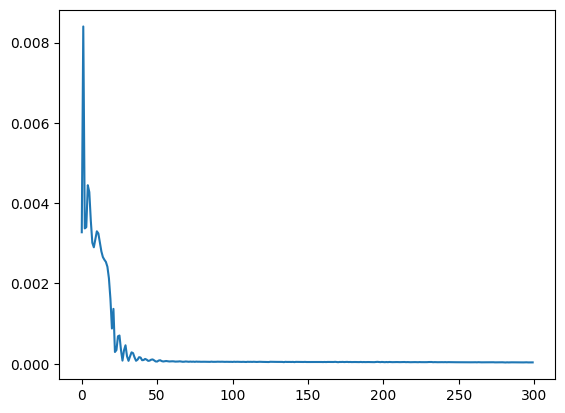

In [360]:
plt.plot(history)
# dplt.plot(history.history['val_loss'])

In [361]:
X_test[0]

array([[0.11406004, 0.11917248, 0.11232136, 0.11438557, 0.11946103,
        0.11793691, 0.1169381 ]])

In [362]:
# X_train_X_test = np.concatenate((X_train, X_test),axis=0)
# hidden_state = None
rnn.eval()
# test_inputs = torch.tensor(X_test).float().cuda()
test_predict, _ = rnn(X_test_cuda, hidden_state)
test_predict_cpu = test_predict.cpu().detach().numpy()

In [363]:
test_predict_cpu.shape

(502, 1, 1)

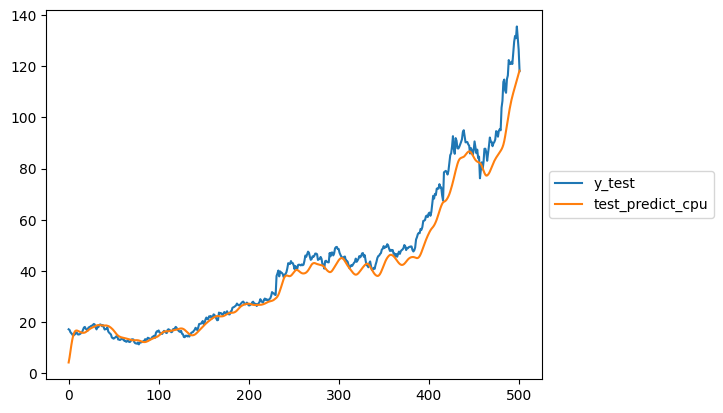

In [364]:
plt.plot(sc.inverse_transform(y_test.reshape(-1,1)))
plt.plot(sc.inverse_transform(test_predict_cpu.reshape(-1,1)))
plt.legend(['y_test','test_predict_cpu'], loc='center left', bbox_to_anchor=(1, 0.5))

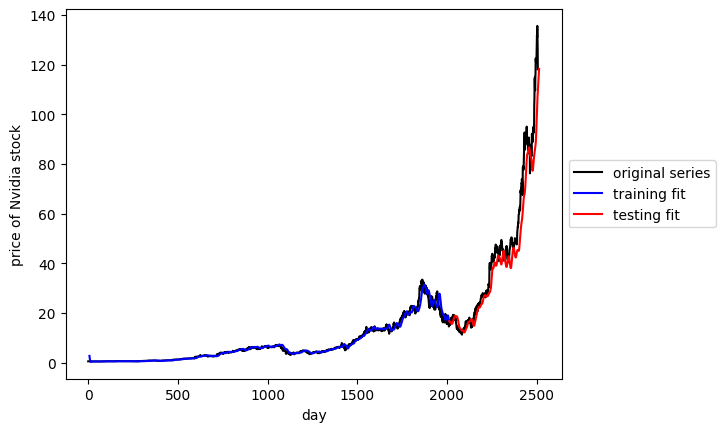

In [365]:
# plot original data
plt.plot(sc.inverse_transform(y.reshape(-1,1)), color='k')

# train_inputs = torch.tensor(X_train).float().cuda()
train_pred, hidden_state = rnn(inputs_cuda, None)
train_pred_cpu = train_pred.cpu().detach().numpy()

# use hidden state from previous training data
test_predict, _ = rnn(X_test_cuda, hidden_state)
test_predict_cpu = test_predict.cpu().detach().numpy()

# plt.plot(scl.inverse_transform(y_test.reshape(-1,1)))
split_pt = int(X.shape[0] * 0.80) + 7 # window_size
plt.plot(np.arange(7, split_pt, 1), sc.inverse_transform(train_pred_cpu.reshape(-1,1)), color='b')
plt.plot(np.arange(split_pt, split_pt + len(test_predict_cpu), 1), sc.inverse_transform(test_predict_cpu.reshape(-1,1)), color='r')

# pretty up graph
plt.xlabel('day')
plt.ylabel('price of Nvidia stock')
plt.legend(['original series','training fit','testing fit'], loc='center left', bbox_to_anchor=(1, 0.5))
plt.show()

In [366]:
MMSE = np.sum((test_predict_cpu.reshape(1,X_test.shape[0])-y[2006:])**2)/X_test.shape[0]
print(MMSE)

0.0018420128176938062


Best: 0.0008247561015664142